使用デバイス: cuda
収束 (iter=48)
最終近似均衡: pN=0.729, pS=0.205
  D_new=0.133, D_sub=0.653, D_no=0.214
  利潤(メーカー)=0.227, 利潤(サブ企業)=0.315


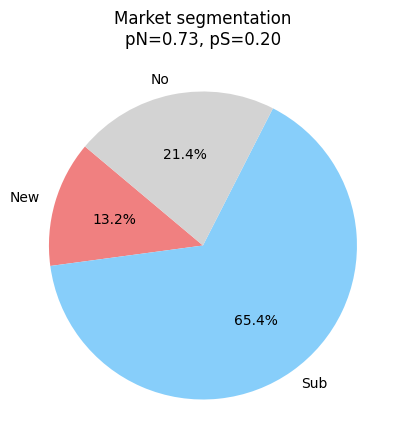

収束 (iter=30)
収束 (iter=23)
収束 (iter=37)
収束 (iter=44)
収束 (iter=21)
収束 (iter=40)
収束 (iter=25)
収束 (iter=18)
収束 (iter=12)
収束 (iter=18)
収束 (iter=15)


/tmp/ipykernel_1097021/595091492.py:162: RuntimeWarning: invalid value encountered in scalar multiply
  return (1 - r_back) * dS * (p_sub - c_sub*delta) * n


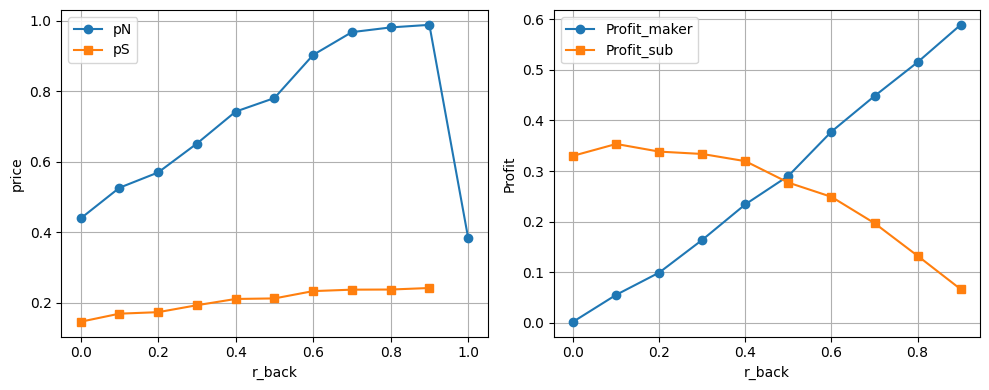

In [27]:
import torch
import numpy as np
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

###############################################################################
# 0. パラメータ全体設定
###############################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用デバイス:", device)

# --- 消費者関連 ---
num_samples = 2000000  # モンテカルロサンプル数
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

# 消費者の期間 n
n = 4

# r の区間
r_min = 0.05
r_max = 0.99

# サブの WTP 割引係数 (消費者はサブスクリプションに対して少し低い評価)
alpha_sub = 0.95

# --- 成本等 ---
c_new  = 0.3    # 新品コスト
c_sub  = 0.02    # サブスク企業のコスト
delta  = 0.2   # 1台あたりの必要台数 (シェアリング効率)

# --- 企業間 ---
r_back = 0.4    # サブスク企業利益をどれだけメーカーにバックするか (0~1)

# --- 価格の探索範囲 ---
price_min = 0.0
price_max = 1.0

# --- 反復アルゴリズム ---
max_iter = 300
tol      = 1e-3
damping  = 0.3  # 価格アップデートのダンピング

###############################################################################
# 1. 消費者効用関数
###############################################################################
def u_new(w, r, p_new):
    """
    新品購入時の効用
      U_new = w * ( (1-r^n)/(1-r) ) - p_new
    """
    if p_new is None or p_new <= 0:
        return torch.full_like(w, -9999.0)

    eps = 1e-12
    r_clamp = torch.clamp(r, eps, 1 - eps)
    factor  = (1 - r_clamp**n) / (1 - r_clamp)

    # 新品の WTP　の present value = w * factor
    # コスト = p_new * 1 (すでにトータル価格として扱う想定)
    return w * factor - p_new


def u_sub(w, r, p_sub):
    """
    サブスク利用時の効用:
      - 期間 n の間、毎期 p_sub を支払う。ただし割引あり
        => 合計支払い  ~=  p_sub * sum_{k=0..n-1}(r^k) = p_sub * factor
      - サブの WTP は alpha_sub * w (やや低い評価)
      - よって: U_sub = （alpha_sub * w - p_sub） * factor
    """
    if p_sub is None or p_sub <= 0:
        return torch.full_like(w, -9999.0)

    eps = 1e-12
    r_clamp = torch.clamp(r, eps, 1 - eps)
    factor  = (1 - r_clamp**n) / (1 - r_clamp) #(present valueの計算)

    return (alpha_sub * w - p_sub)* factor

###############################################################################
# 2. 需要関数
###############################################################################
def demand_new(p_new, p_sub):
    """
    新品を選ぶ消費者割合
    """
    if p_new is None or p_new <= 0:
        return 0.0

    w = torch.rand(num_samples, device=device)
    r = r_min + (r_max - r_min) * torch.rand(num_samples, device=device)

    un = u_new(w, r, p_new)
    us = u_sub(w, r, p_sub)

    # 両方 <0 => no consumption
    no_mask = (un < 0) & (us < 0)
    new_mask = (un >= us) & (~no_mask)

    return new_mask.float().mean().item()


def demand_sub(p_new, p_sub):
    """
    サブスクを選ぶ消費者割合
    """
    if p_sub is None or p_sub <= 0:
        return 0.0

    w = torch.rand(num_samples, device=device)
    r = r_min + (r_max - r_min) * torch.rand(num_samples, device=device)

    un = u_new(w, r, p_new)
    us = u_sub(w, r, p_sub)

    no_mask = (un < 0) & (us < 0)
    sub_mask = (us > un) & (~no_mask)

    return sub_mask.float().mean().item()

def demand_no(p_new, p_sub):
    """
    何も選ばない(両方の効用<0) 消費者割合
    """
    w = torch.rand(num_samples, device=device)
    r = r_min + (r_max - r_min)*torch.rand(num_samples, device=device)

    un = u_new(w, r, p_new)
    us = u_sub(w, r, p_sub)

    no_mask = (un<0) & (us<0)
    return no_mask.float().mean().item()

###############################################################################
# 3. 企業の利潤
###############################################################################
def profit_maker(p_new, p_sub):
    """
    メーカーの利潤:
      pi_maker = D_new * (p_new - c_new)
                 + r_back * [ D_sub * (p_sub - c_sub) * n ]
                 - D_sub * c_new * delta
    """
    dN = demand_new(p_new, p_sub)          # 新品需求
    dS = demand_sub(p_new, p_sub)          # 订阅需求

    # サブ企業の総粗利(期間合計)
    sub_gross = dS * (p_sub - c_sub*delta) * n
    
    # メーカーの利潤: 新品利润 + 从订阅收入中获取的r_back分 - 为订阅需求提供产品的成本
    return dN*(p_new - c_new) + r_back*sub_gross - dS*c_new*delta


def profit_sub(p_new, p_sub):
    """
    サブ企業の利潤:
      pi_sub = (1 - r_back) * [ D_sub * (p_sub - c_sub) * n ]
    """
    dS = demand_sub(p_new, p_sub)          # 订阅需求
    return (1 - r_back) * dS * (p_sub - c_sub*delta) * n

###############################################################################
# 4. 価格ゲーム: 最適反応
###############################################################################
def best_response_maker(p_sub):
    """
    メーカーが相手(p_sub)を所与として自社利潤を最大化する p_new を探す
    """
    res = minimize_scalar(
        lambda pN: -profit_maker(pN, p_sub),
        bounds=(price_min, price_max),
        method='bounded'
    )
    best_pN = res.x
    best_pi = -res.fun
    if best_pi <= 0:
        return None
    return best_pN

def best_response_sub(p_new):
    """
    サブ企業が p_new を所与として自社利潤を最大化する p_sub を探す
    """
    res = minimize_scalar(
        lambda pS: -profit_sub(p_new, pS),
        bounds=(price_min, price_max),
        method='bounded'
    )
    best_pS = res.x
    best_pi = -res.fun
    if best_pi <= 0:
        return None
    return best_pS

###############################################################################
# 5. 均衡価格の探索
###############################################################################
def find_equilibrium_prices(pN_init=0.5, pS_init=0.5):
    """
    シンプルな逐次最適反応の繰り返し
    """
    pN = pN_init
    pS = pS_init

    for i in range(max_iter):
        oldN, oldS = pN, pS

        brN = best_response_maker(oldS)
        brS = best_response_sub(oldN)

        # 利潤<=0 なら退出
        if brN is None or profit_maker(brN, oldS) <= 0:
            brN = float('inf')
        if brS is None or profit_sub(oldN, brS) <= 0:
            brS = float('inf')

        if brN == float('inf'):
            pN = float('inf')
        else:
            pN = damping * brN + (1 - damping) * oldN

        if brS == float('inf'):
            pS = float('inf')
        else:
            pS = damping * brS + (1 - damping) * oldS

        # 収束判定
        dist = 0
        if pN != float('inf') and oldN != float('inf'):
            dist += (pN - oldN)**2
        if pS != float('inf') and oldS != float('inf'):
            dist += (pS - oldS)**2
        dist = dist**0.5

        if dist < tol:
            print(f"収束 (iter={i+1})")
            return pN, pS

    print("警告: 収束しませんでした。最終値を返します。")
    return pN, pS

###############################################################################
# 6. グラフ描画用: 市場分割
###############################################################################
def plot_market_segmentation(pN, pS):
    """
    与えられた pN, pS の下で、消費者が New / Sub / No のどれを選ぶか
    の分割を可視化する。
    """
    # モンテカルロサンプル
    w = torch.rand(num_samples, device=device)
    r = r_min + (r_max - r_min) * torch.rand(num_samples, device=device)

    un = u_new(w, r, pN)
    us = u_sub(w, r, pS)

    # どちらも <0 => no
    no_mask = (un < 0) & (us < 0)
    # new_mask
    new_mask = (un >= us) & (~no_mask)
    # sub_mask
    sub_mask = (us > un) & (~no_mask)

    # 計算
    frac_no  = no_mask.float().mean().item()
    frac_new = new_mask.float().mean().item()
    frac_sub = sub_mask.float().mean().item()

    plt.figure(figsize=(5, 5))
    labels = ["New", "Sub", "No"]
    sizes = [frac_new, frac_sub, frac_no]
    colors = ["lightcoral", "lightskyblue", "lightgray"]
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title(f"Market segmentation\npN={pN:.2f}, pS={pS:.2f}")
    plt.show()

###############################################################################
# 7. グラフ描画用: r_back による感度分析
###############################################################################
def sensitivity_r_back(r_back_values, pN_init=0.5, pS_init=0.5):
    """
    r_back を変化させながら均衡価格 (pN, pS) と、両社の利潤を記録してプロットする。
    """
    results = []
    global r_back

    for rb in r_back_values:
        r_back = rb  # グローバル変数を更新
        pN_eq, pS_eq = find_equilibrium_prices(pN_init, pS_init)

        piN = profit_maker(pN_eq, pS_eq)
        piS = profit_sub(pN_eq, pS_eq)

        results.append((rb, pN_eq, pS_eq, piN, piS))

    # プロット
    arr = np.array(results)
    # arr[:,0] = r_back, arr[:,1]=pN, arr[:,2]=pS, arr[:,3]=piN, arr[:,4]=piS

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # 左図: pN, pS の変化
    ax[0].plot(arr[:,0], arr[:,1], 'o-', label='pN')
    ax[0].plot(arr[:,0], arr[:,2], 's-', label='pS')
    ax[0].set_xlabel("r_back")
    ax[0].set_ylabel("price")
    ax[0].legend()
    ax[0].grid(True)

    # 右図: 利潤の変化
    ax[1].plot(arr[:,0], arr[:,3], 'o-', label='Profit_maker')
    ax[1].plot(arr[:,0], arr[:,4], 's-', label='Profit_sub')
    ax[1].set_xlabel("r_back")
    ax[1].set_ylabel("Profit")
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

###############################################################################
# 8. メイン実行例
###############################################################################
if __name__ == "__main__":
    # 1) 均衡価格の探索
    pN_init = 0.5
    pS_init = 0.5

    eq_pN, eq_pS = find_equilibrium_prices(pN_init, pS_init)
    print(f"最終近似均衡: pN={eq_pN:.3f}, pS={eq_pS:.3f}")
    print(f"  D_new={demand_new(eq_pN, eq_pS):.3f}, D_sub={demand_sub(eq_pN, eq_pS):.3f}, D_no={demand_no(eq_pN, eq_pS):.3f}")
    print(f"  利潤(メーカー)={profit_maker(eq_pN, eq_pS):.3f}, 利潤(サブ企業)={profit_sub(eq_pN, eq_pS):.3f}")

    # 2) 市場分割を円グラフで可視化
    plot_market_segmentation(eq_pN, eq_pS)

    # 3) r_back を [0,1] の範囲で変化させたときの感度分析
    r_back_list = np.linspace(0, 1, 11)  # 0,0.1,...,1.0
    sensitivity_r_back(r_back_list, pN_init=0.5, pS_init=0.5)